<a href="https://www.kaggle.com/code/prasadckulkarni/is-it-jason-statham-or-akshay-khanna-lesson-2?scriptVersionId=113029360" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

*this is edit of Notebook by Jeremey Howard which was done to distinguish bird and forest photos, am using the same notebook to distinguish between Jason Statham and Akshay Khanna*

## Is it Jason statham or Akshay Khanna?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-tran

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "Jason Statham photos"
1. Use DuckDuckGo to search for images of "Akshay Khanna photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of an actor and see if it works.

## Step 1: Download images of Jason Statham and Akshaye Khanna 

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a Jason statham photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Jason statham', max_images=1)
urls[0]

Searching for 'Jason statham'


'http://de.web.img2.acsta.net/pictures/19/07/31/17/35/5396784.jpg'

...and then download a URL and take a look at it:

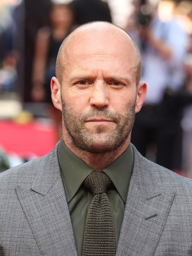

In [5]:
from fastdownload import download_url
dest = 'Jason_statham.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "Akshaye_Khanna":

Searching for 'Akshaye Khanna'


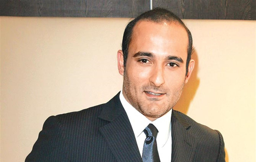

In [6]:
download_url(search_images('Akshaye Khanna', max_images=1)[0], 'Akshaye_Khanna.jpg', show_progress=False)
Image.open('Akshaye_Khanna.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "Jason statham" and "Akshaye_Khanna" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
searches = 'Akshaye Khanna','Jason statham'
path = Path('Jason statham_or_Akshaye Khanna')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} fighter photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} silent photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Akshaye Khanna photo'
Searching for 'Akshaye Khanna fighter photo'
Searching for 'Akshaye Khanna silent photo'
Searching for 'Jason statham photo'
Searching for 'Jason statham fighter photo'
Searching for 'Jason statham silent photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

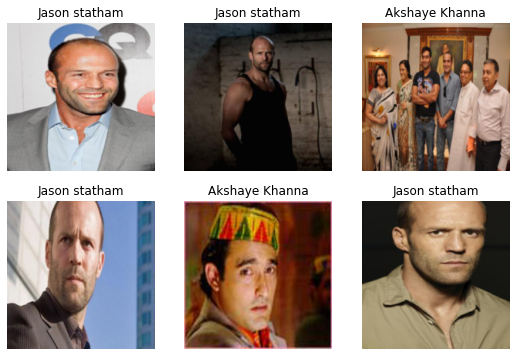

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)



Learning using a pre-trained model and fine tuning

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.131060,0.640090,0.343750,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.709682,0.412536,0.187500,00:01
1,0.489409,0.363245,0.093750,00:01
2,0.357754,0.341535,0.093750,00:01


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [11]:
Akshaye_Khanna,_,probs = learn.predict(PILImage.create('Akshaye_Khanna.jpg'))
print(f"This is a: {Akshaye_Khanna}.")
print(f"Probability it's Akshaye_Khanna: {probs[0]:.4f}")

This is a: Akshaye Khanna.
Probability it's Akshaye_Khanna: 0.9495


#jeremy's notebook ends here and here onwards is my own work
#In Lesson 2 ,  i am practicing the following learnings:
#At any point, if you don't remember the exact spelling of a function or argument name, you can press Tab to get autocompletion suggestions.

#When inside the parentheses of a function, pressing Shift and Tab simultaneously will display a window with the signature of the function and a short description. Pressing these keys twice will expand the documentation, and pressing them three times will open a full window with the same information at the bottom of your screen.

#In a cell, typing ?func_name and executing will open a window with the signature of the function and a short description.

#In a cell, typing ??func_name and executing will open a window with the signature of the function, a short description, and the source code.

#If you are using the fastai library, we added a doc function for you: executing doc(func_name) in a cell will open a window with the signature of the function, a short description and links to the source code on GitHub and the full documentation of the function in the library docs.

#Unrelated to the documentation but still very useful: to get help at any point if you get an error, type %debug in the next cell and execute to open the Python debugger, which will let you inspect the content of every variable.

In [12]:
?verify_images

In [13]:
#types verif and pressed Tab , got suggestions
verify_images

<function fastai.vision.utils.verify_images(fns)>

In [14]:
??verify_images

In [15]:
doc(verify_images)

verify_images(fns)
Find images in `fns` that can't be opened

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [16]:
pip install nbdev

     |████████████████████████████████| 64 kB 675 kB/s            
     |████████████████████████████████| 78 kB 1.9 MB/s            
     |████████████████████████████████| 58 kB 3.2 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [17]:
doc(verify_images)

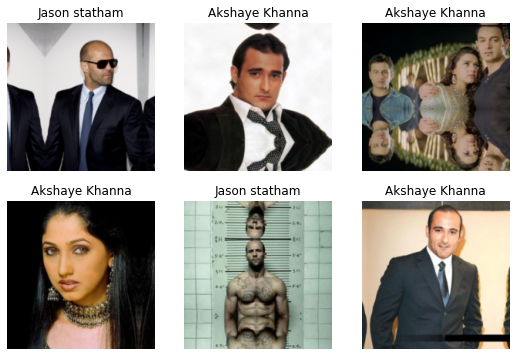

In [18]:
#here problem am facing is that i want to just change the transform method to pad but 
#dls=dls.new(item_tfms=Resize(128,ResizeMethod.Pad,pad_mode='zeros')).dataloaders(path)
#is giving "list out of index error", so i used complete DataBlock again with Pad method
#Learning:simply using pad gives mirror image like below

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='pad')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

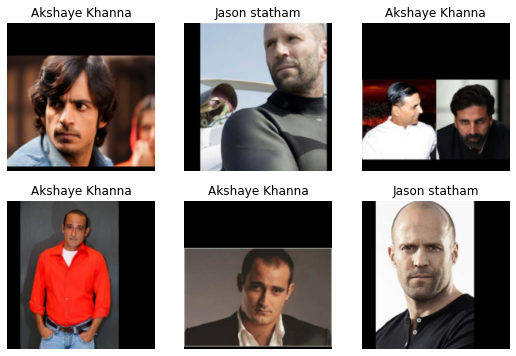

In [19]:
#difference i made from above code is to use pad_mode="zeros"
#self learned this..
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='pad',pad_mode="zeros")]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [20]:
??DataBlock

In [21]:
#now let's train this model with Pad method

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)


epoch,train_loss,valid_loss,error_rate,time
0,1.088210,0.635270,0.375000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.765775,0.525010,0.250000,00:01
1,0.561854,0.537429,0.250000,00:01
2,0.426390,0.487773,0.218750,00:01


In [22]:
Akshaye_Khanna,_,probs = learn.predict(PILImage.create('Akshaye_Khanna.jpg'))
print(f"This is a: {Akshaye_Khanna}.")
print(f"Probability it's Akshaye_Khanna: {probs[0]:.4f}")

This is a: Akshaye Khanna.
Probability it's Akshaye_Khanna: 0.5891


In [23]:
Jason_statham,_,probs = learn.predict(PILImage.create('Jason_statham.jpg'))
print(f"This is a: {Jason_statham}.")
print(f"Probability it's Jason_statham: {probs[0]:.4f}")
#Dont know why my model is unable to recognize Jason statham , will figure it out at later stages

This is a: Jason statham.
Probability it's Jason_statham: 0.0000


**Data Augmentation**

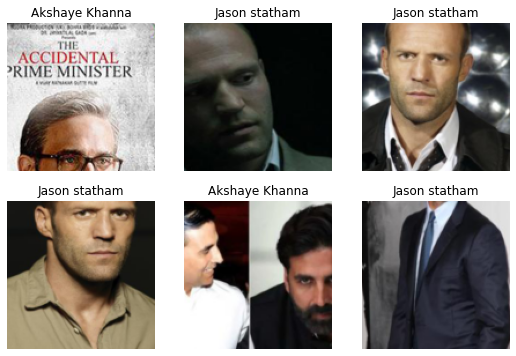

In [24]:
#let's learn data augmentation
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[ RandomResizedCrop(128,min_scale=0.3)]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

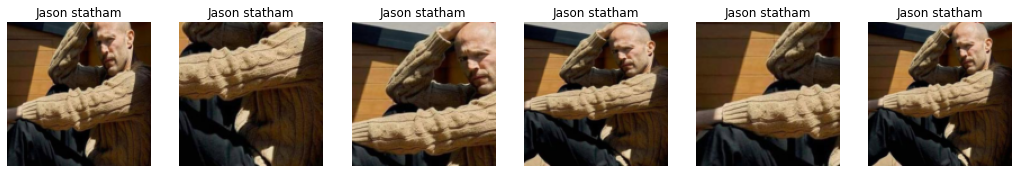

In [25]:
#lets add nrows and unique=True
#what unique=True does is that it uses same image with different crop versions
#let's learn data augmentation
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[ RandomResizedCrop(128,min_scale=0.3)]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6,nrows=1,unique=True)

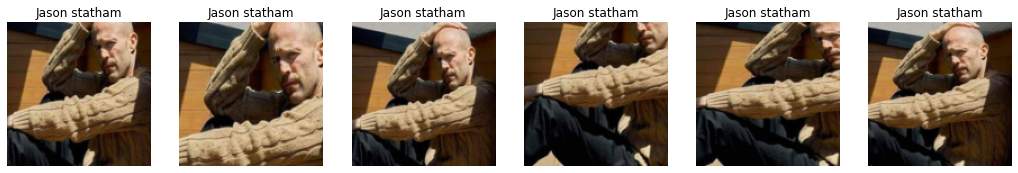

In [26]:
#lets run the above block once again to see which image it picks up to focus this time
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[ RandomResizedCrop(128,min_scale=0.3)]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6,nrows=1,unique=True)

#its the same coz we set the seed =42, we need to change this seed value to get different image

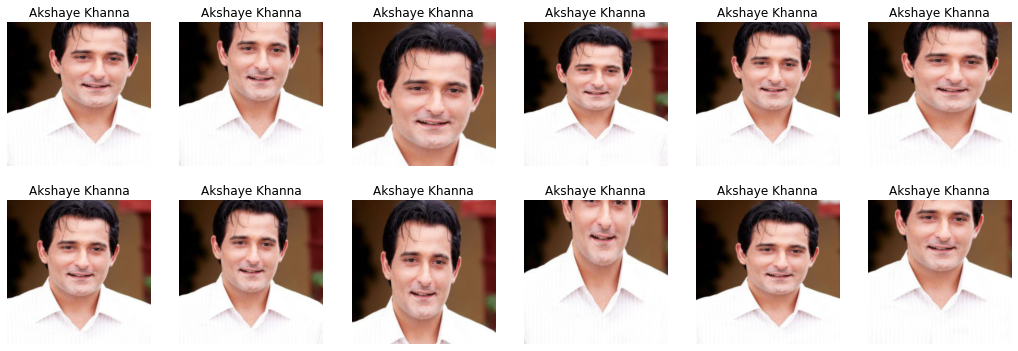

In [27]:
#Playing with the DataBlock parameters
#i changed the seed to 52 , so now we have different image and also i change min_scale to 0.4 so that 40% of the image is taken each time
#and changed pixels from 128 to 256, max_n=12, nrows=2
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=52),
    get_y=parent_label,
    item_tfms=[ RandomResizedCrop(256,min_scale=0.4)]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12,nrows=2,unique=True)

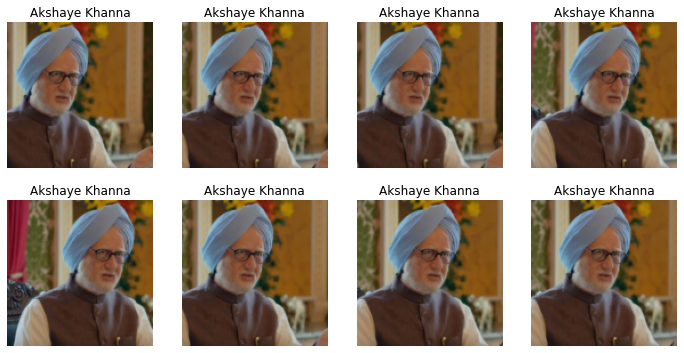

In [28]:
#Using Aug_transforms
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=32),
    get_y=parent_label,
    item_tfms=Resize(128),batch_tfms=aug_transforms
).dataloaders(path, bs=32)

dls.show_batch(max_n=8,nrows=2,unique=True)
#unable to see any difference here, so need to tweak parameters

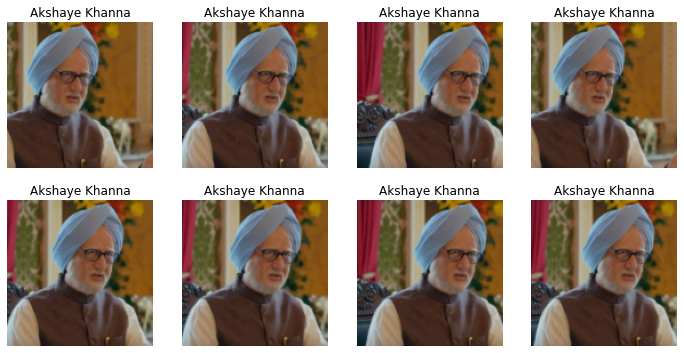

In [29]:
#changed seed value as i want to see different image
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=32),
    get_y=parent_label,
    item_tfms=Resize(128),batch_tfms=aug_transforms
).dataloaders(path, bs=32)

dls.show_batch(max_n=8,nrows=2,unique=True)


In [30]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.967372,0.579994,0.343750,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.771609,0.396053,0.156250,00:00
1,0.593841,0.444776,0.156250,00:00
2,0.473046,0.467501,0.156250,00:00


Open question to explore:
If i use (mult=2) in
    item_tfms=Resize(128),batch_tfms=aug_transforms (mult=2)
its saying that MAGMA library not found in compilation,
I need to see what went wrong...

**Training Your Model, and Using It to Clean Your Data**

Now we will train our model with Random resized crop using aug transforms
Significance:Random resized crop will present random parts of the image and aug transform will 
just create different versions of the crop by stretching or compressing, making it bright or dull
so that our model can understand better

In [31]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=32),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224,min_scale=0.5),batch_tfms=aug_transforms
).dataloaders(path, bs=32)


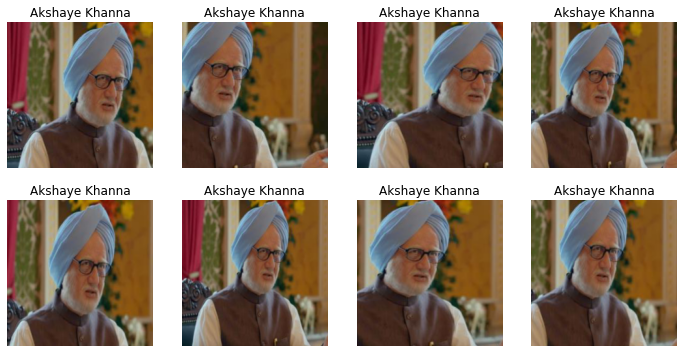

In [32]:
dls.show_batch(max_n=8,nrows=2,unique=True)


In [33]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.826596,1.248074,0.468750,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.641139,0.943127,0.375000,00:01
1,0.514989,0.622665,0.218750,00:01
2,0.400093,0.510474,0.218750,00:01


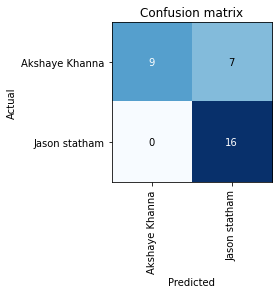

In [34]:
#now i want to see how my model is performing actually so
#creating a confusion matrix
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**why we are building and training a model first and then cleaning it?**

My explanation:When we train a model and look for losses , we get to know from where they are coming 
so we can focus on that specific category for cleanup
On the other hand , if we blindly start cleanup activity before model training then we dont know specifically where the 
model is facing problem in identifying a category

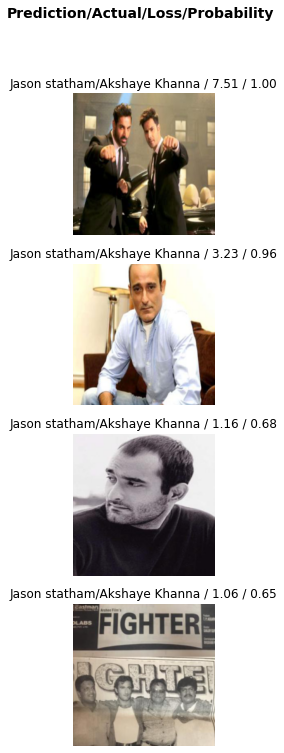

In [35]:
interp.plot_top_losses(4,nrows=4)
#Interpretation: use interp variable to plot top losses and show me losses for 6 images in 4 rows

From above loss analysis, i can infer that data cleaning is required for Akshaye Khanna
correct labels are not there for Akshaye Khanna, 
surprisingly some images contain neither of the actors but they are labelled , 
maybe due to this the model faced difficulties in identifying Jason